In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
from sklearn.utils import class_weight
from tensorflow.python.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import numpy as np
tf.random.set_seed(123)
np.random.seed(7)

In [2]:
def get_dataframe():
    df = pd.read_csv("10percent_cut.tsv", sep='\t')
    return df

In [3]:
def load_dataset(df):
    train, test = train_test_split(df[['transcription', 'label']], train_size=0.7, random_state=123)

    train_texts = train['transcription'].values
    train_label = train['label'].values

    validation_texts = test['transcription'].values
    validation_label = test['label'].values

#     train_texts = remove_float_instances(train_texts_tmp)
#     validation_texts = remove_float_instances(validation_texts_tmp)

    return train_texts, train_label, validation_texts, validation_label


In [4]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [5]:
def create_alphabet(dataframe):
    category_lines = {1: [], 0: []}
    all_categories = [0, 1]
    alphabet = set()

    for index, row in dataframe.iterrows():
        ascii_transcription = row['transcription']
        tokenized_transcription = [char for char in ascii_transcription]
        for token in tokenized_transcription:
            alphabet.add(token)

        category_lines[row['label']].append(ascii_transcription)

    N_LETTERS = len(alphabet)
    ALL_LETTERS = ''.join(alphabet)
    return N_LETTERS, ALL_LETTERS

In [6]:
def sequence_to_embeddings(tokenizer, train_texts, validation_texts):
    sequences = tokenizer.texts_to_sequences(train_texts)
    validation_sequences = tokenizer.texts_to_sequences(validation_texts)
    # print(train_texts[0])
    # print(sequences[0])
    data = pad_sequences(sequences, maxlen=750, padding='post')
    validation_data = pad_sequences(validation_sequences, maxlen=750, padding='post')
    return data, validation_data


In [12]:
def define_model(input_dimension, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            input_dim=input_dimension,
            output_dim=128),
        tf.keras.layers.LSTM(128),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # %%
    # model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    #               optimizer=tf.keras.optimizers.Adam(1),
    #               metrics=['}accuracy'])

    # opt = SGD(lr=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

    return model

In [8]:
%%time
df = get_dataframe()
train_texts, train_label, validation_texts, validation_label = load_dataset(df)
tokenizer = Tokenizer(num_words=None, char_level=True, oov_token='UNK', lower=False)
tokenizer.fit_on_texts(train_texts)

CPU times: user 30.3 s, sys: 376 ms, total: 30.7 s
Wall time: 30.7 s


In [9]:
N_LETTERS, ALL_LETTERS = create_alphabet(df)
char_dict = {}
for i, char in enumerate(ALL_LETTERS):
    char_dict[char] = i + 1
print(char_dict)

{'R': 1, 't': 2, ';': 3, '$': 4, '&': 5, '\t': 6, 'w': 7, '(': 8, 'm': 9, '1': 10, '5': 11, '!': 12, '_': 13, '@': 14, ',': 15, 'Z': 16, 'v': 17, 'p': 18, '0': 19, 'X': 20, '+': 21, 'B': 22, '7': 23, 'W': 24, '9': 25, '#': 26, 'D': 27, 'Y': 28, ':': 29, ' ': 30, '\n': 31, '*': 32, 'Q': 33, 'd': 34, 'a': 35, '2': 36, 'n': 37, 'f': 38, 'b': 39, '[': 40, '`': 41, 'U': 42, '3': 43, '4': 44, 'I': 45, "'": 46, 'l': 47, 'e': 48, 'r': 49, ')': 50, 'o': 51, '^': 52, 'T': 53, '%': 54, '/': 55, '"': 56, 'N': 57, '-': 58, 'V': 59, ']': 60, 'A': 61, 's': 62, '\\': 63, '.': 64, 'x': 65, 'c': 66, '6': 67, '8': 68, 'P': 69, 'S': 70, '?': 71, 'i': 72}


In [10]:
%%time
tokenizer.word_index = char_dict
tokenizer.word_index[tokenizer.oov_token] = max(char_dict.values()) + 1

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.2 µs


In [11]:
%%time
data, validation_data = sequence_to_embeddings(tokenizer=tokenizer, train_texts=train_texts,
                                           validation_texts=validation_texts)

CPU times: user 43.8 s, sys: 988 ms, total: 44.8 s
Wall time: 44.8 s


# Non-loop version 

In [40]:
input_dimension = len(char_dict.values())
model = define_model(input_dimension=input_dimension, learning_rate=0.001)
class_weights = dict(zip(np.unique(train_label), class_weight.compute_class_weight('balanced', np.unique(train_label), train_label)))

In [41]:
history = model.fit(x=data, y=train_label, epochs=1, class_weight=class_weights)

89/89 [==============================] - 35s 375ms/step - loss: 0.0000e+00 - accuracy: 0.0842


In [30]:
test_loss, test_acc = model.evaluate(x=validation_data, y=validation_label)

39/39 [==============================] - 5s 114ms/step - loss: 0.0000e+00 - accuracy: 0.0738


In [39]:
predictions = model.predict_classes(x=validation_data)
confusion = tf.math.confusion_matrix(labels=validation_label, predictions=predictions, num_classes=2)
print(confusion)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


tf.Tensor(
[[   0 1129]
 [   0   90]], shape=(2, 2), dtype=int32)


KeyError: 'val_accuracy'

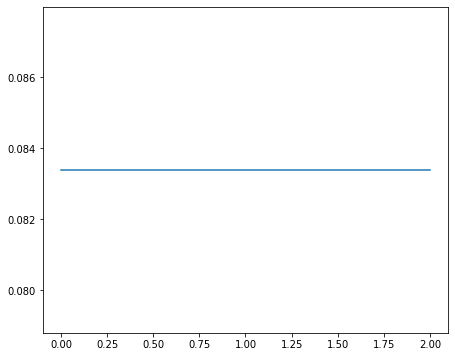

In [36]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# Loop version for finding best learning rate

In [ ]:
learning_rates = np.linspace(0.00001, 0.00000001, 20) #[1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
accuracies = []
confusion_matrices = []
tf.random.set_seed(123)
np.random.seed(7)

for learning_rate in learning_rates:
    input_dimension = len(char_dict.values())
    model = define_model(input_dimension=input_dimension, learning_rate=learning_rate)
    class_weights = dict(zip(np.unique(train_label), class_weight.compute_class_weight('balanced', np.unique(train_label), train_label)))

    history = model.fit(x=data, y=train_label, epochs=5, class_weight=class_weights)

    test_loss, test_acc = model.evaluate(x=validation_data, y=validation_label)

    predictions = model.predict_classes(x=validation_data)
    confusion = tf.math.confusion_matrix(labels=validation_label, predictions=predictions, num_classes=2)
    
    print(confusion)
    
    accuracies.append(test_acc)
    confusion_matrices.append(confusion)

# Numpy saving & loading preprocessed arrays

In [16]:
# Saving data & validation data to prevent preprocessing
#np.savetxt('validation_numpy.txt', validation_data, fmt='%d')
#np.savetxt('data_numpy.txt', data, fmt='%d')

In [8]:
data = np.loadtxt('data_numpy.txt', dtype=int)
validation_data = np.loadtxt('validation_numpy.txt', dtype=int)